Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
import seaborn as sns

In [6]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
import pathlib

# Define your directories
data_dir_train = pathlib.Path("C:/Users/sridh/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("C:/Users/sridh/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

# Define common image file extensions
image_extensions = {".jpg"}

# Filter images by checking the file extension
train_images = [p for p in data_dir_train.rglob("*") if p.suffix.lower() in image_extensions]
test_images = [p for p in data_dir_test.rglob("*") if p.suffix.lower() in image_extensions]

print(f"Total train images found: {len(train_images)}")
print(f"Total test images found: {len(test_images)}")


Total train images found: 2239
Total test images found: 118


In [8]:
image_count_train = len(list(data_dir_train.glob('**/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('**/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,  # Using the same directory as training
    validation_split=0.2,
    subset="validation",  # This time we use "validation" subset
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

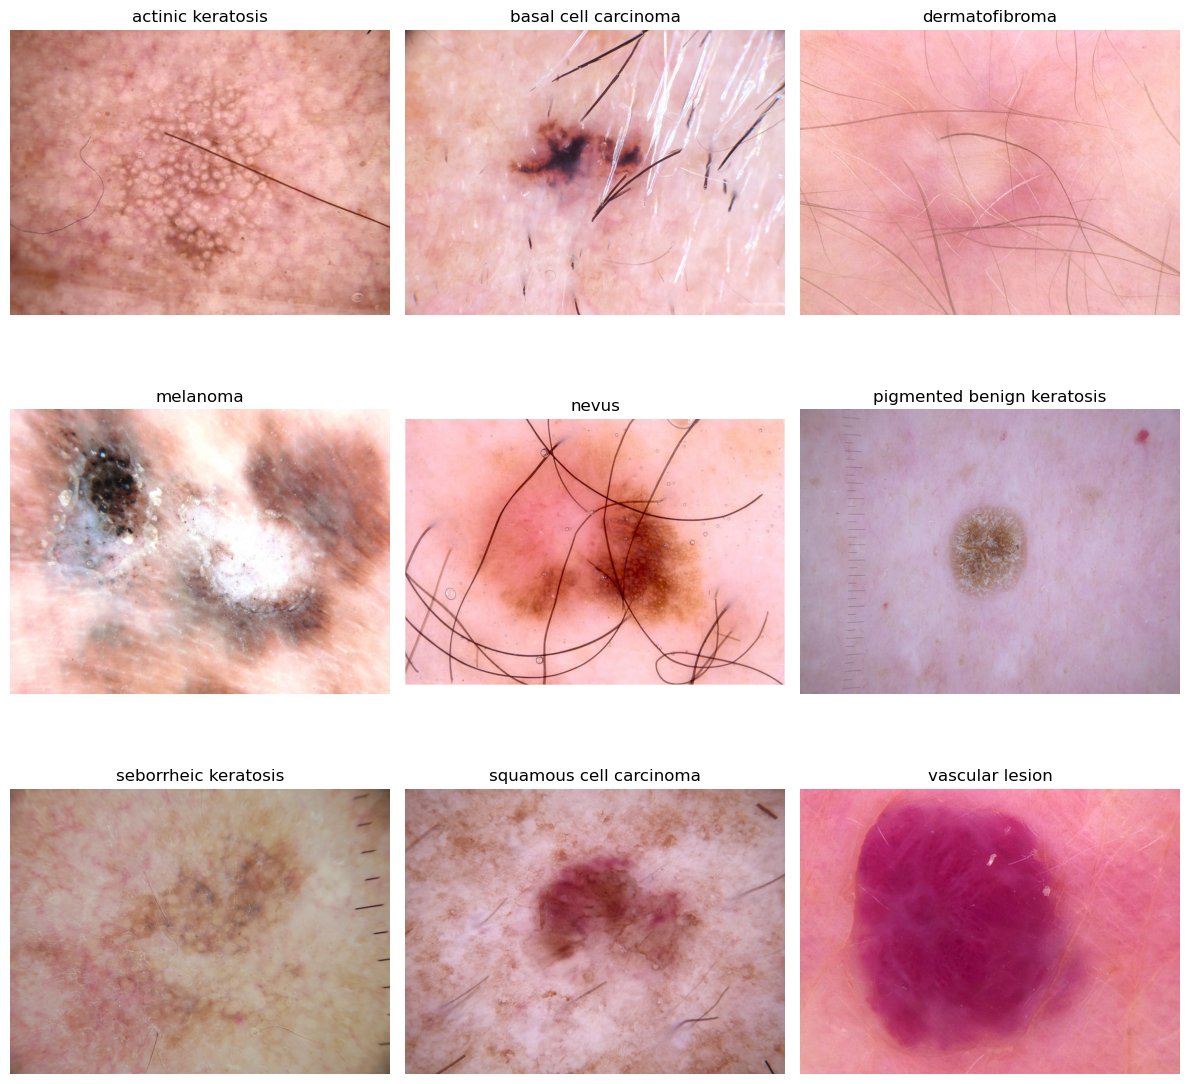

In [13]:
import matplotlib.pyplot as plt
import random
from PIL import Image
from pathlib import Path

# Ensure data_dir_train is defined as a Path to your training directory
# Example: data_dir_train = Path("path/to/your/training/data")

class_names = [d.name for d in data_dir_train.iterdir() if d.is_dir()]
class_names.sort()  # Sorting for consistency

# Dictionary to store one image per class
class_images = {}

# Collect one image per class
for class_name in class_names:
    class_path = data_dir_train / class_name
    # Corrected glob patterns without extra quotes
    images = list(class_path.glob("**/*.jpg")) + list(class_path.glob("**/*.png"))
    
    if images:  # Check if images exist
        class_images[class_name] = random.choice(images)  # Pick a random image

# Plot images (assuming there are exactly 9 classes; adjust grid if needed)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for ax, (class_name, img_path) in zip(axes, class_images.items()):
    img = Image.open(img_path).convert("RGB")  # Ensure image is fully loaded and in RGB mode
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis("off")

plt.tight_layout()
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [45]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [46]:
num_classes = len(class_names)
model = tf.keras.Sequential([
 layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax') 
])
     

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [49]:
# View the summary of all layers
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [50]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.2036 - loss: 2.1750 - val_accuracy: 0.3177 - val_loss: 1.8288
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.4288 - loss: 1.6541 - val_accuracy: 0.5257 - val_loss: 1.4083
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5202 - loss: 1.3839 - val_accuracy: 0.5436 - val_loss: 1.4063
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5469 - loss: 1.3271 - val_accuracy: 0.5526 - val_loss: 1.3906
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.5948 - loss: 1.2069 - val_accuracy: 0.5302 - val_loss: 1.4727
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5956 - loss: 1.1603 - val_accuracy: 0.5436 - val_loss: 1.4861
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.6190 - loss: 1.1058 - val_accuracy: 0.5705 - val_loss: 1.3600
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.6623 - loss: 0.9419 - val_accuracy: 0.5526 - v

### Visualizing training results

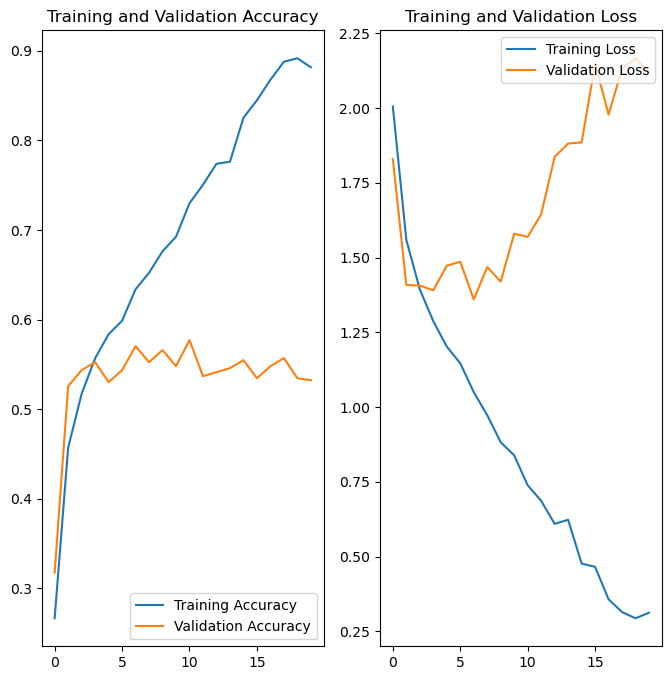

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here

#### Observation: There is a overfitting ! Training Accuracy is high and Validation Accuracy is low

In [52]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

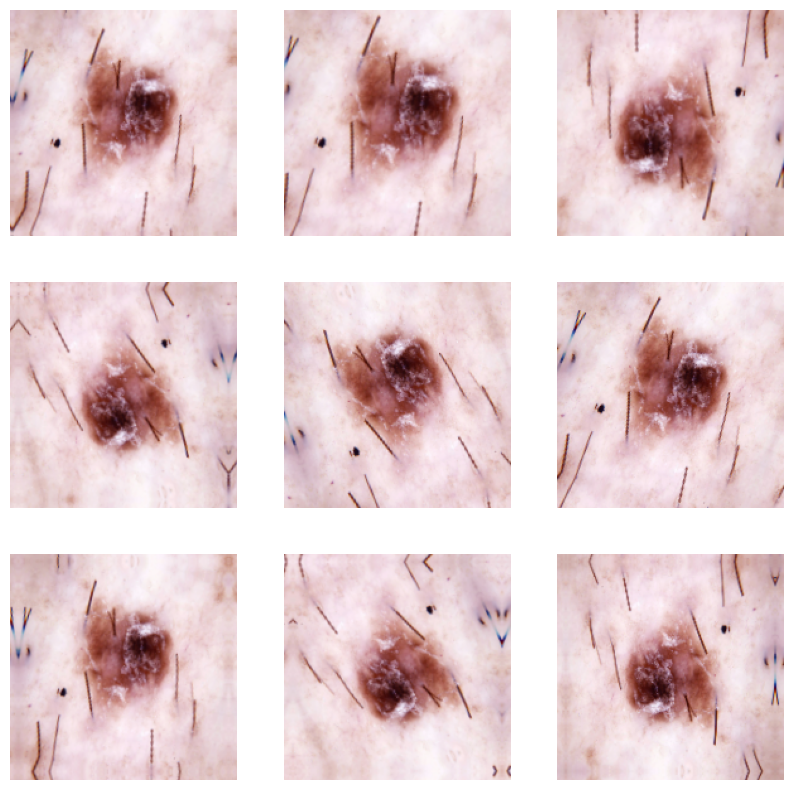

In [53]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [54]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.2),
  layers.Flatten(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')  
])


### Compiling the model

In [55]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Training the model

In [56]:
## Your code goes here, note: train your model for 20 epochs
history = history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.2082 - loss: 2.1742 - val_accuracy: 0.2260 - val_loss: 1.9600
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.2654 - loss: 1.9240 - val_accuracy: 0.4631 - val_loss: 1.6245
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.4470 - loss: 1.5611 - val_accuracy: 0.4228 - val_loss: 1.6439
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.4834 - loss: 1.4844 - val_accuracy: 0.5414 - val_loss: 1.3726
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.5133 - loss: 1.3264 - val_accuracy: 0.5213 - val_loss: 1.3602
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.5324 - loss: 1.2744 - val_accuracy: 0.5078 - val_loss: 1.4505
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.5590 - loss: 1.2604 - val_accuracy: 0.5481 - val_loss: 1.3039
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.5334 - loss: 1.3111 - val_accuracy: 0.5481 - v

### Visualizing the results

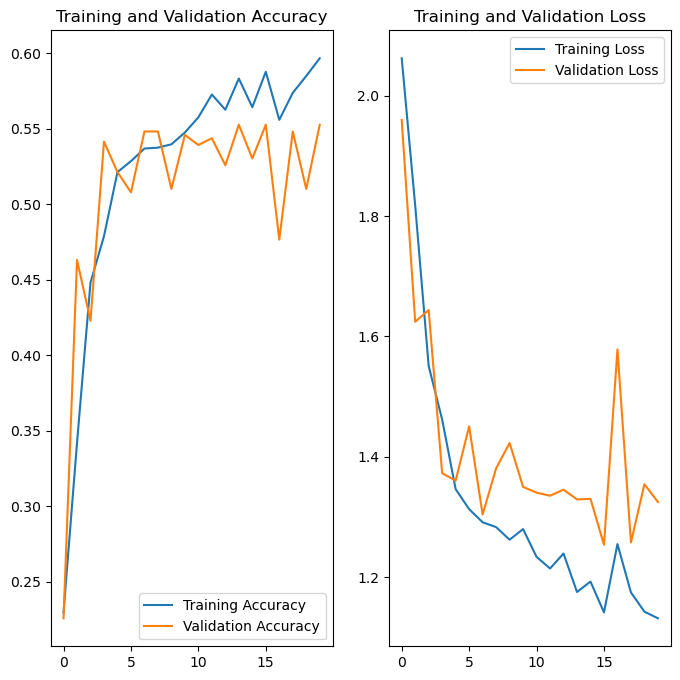

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation : Overfitting issue has been resolved to an extent. Accuracy is still on lowerside

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [58]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,C:\Users\sridh\Downloads\CNN_assignment\Skin c...,actinic keratosis
1,C:\Users\sridh\Downloads\CNN_assignment\Skin c...,actinic keratosis
2,C:\Users\sridh\Downloads\CNN_assignment\Skin c...,actinic keratosis
3,C:\Users\sridh\Downloads\CNN_assignment\Skin c...,actinic keratosis
4,C:\Users\sridh\Downloads\CNN_assignment\Skin c...,actinic keratosis
...,...,...
2234,C:\Users\sridh\Downloads\CNN_assignment\Skin c...,vascular lesion
2235,C:\Users\sridh\Downloads\CNN_assignment\Skin c...,vascular lesion
2236,C:\Users\sridh\Downloads\CNN_assignment\Skin c...,vascular lesion
2237,C:\Users\sridh\Downloads\CNN_assignment\Skin c...,vascular lesion


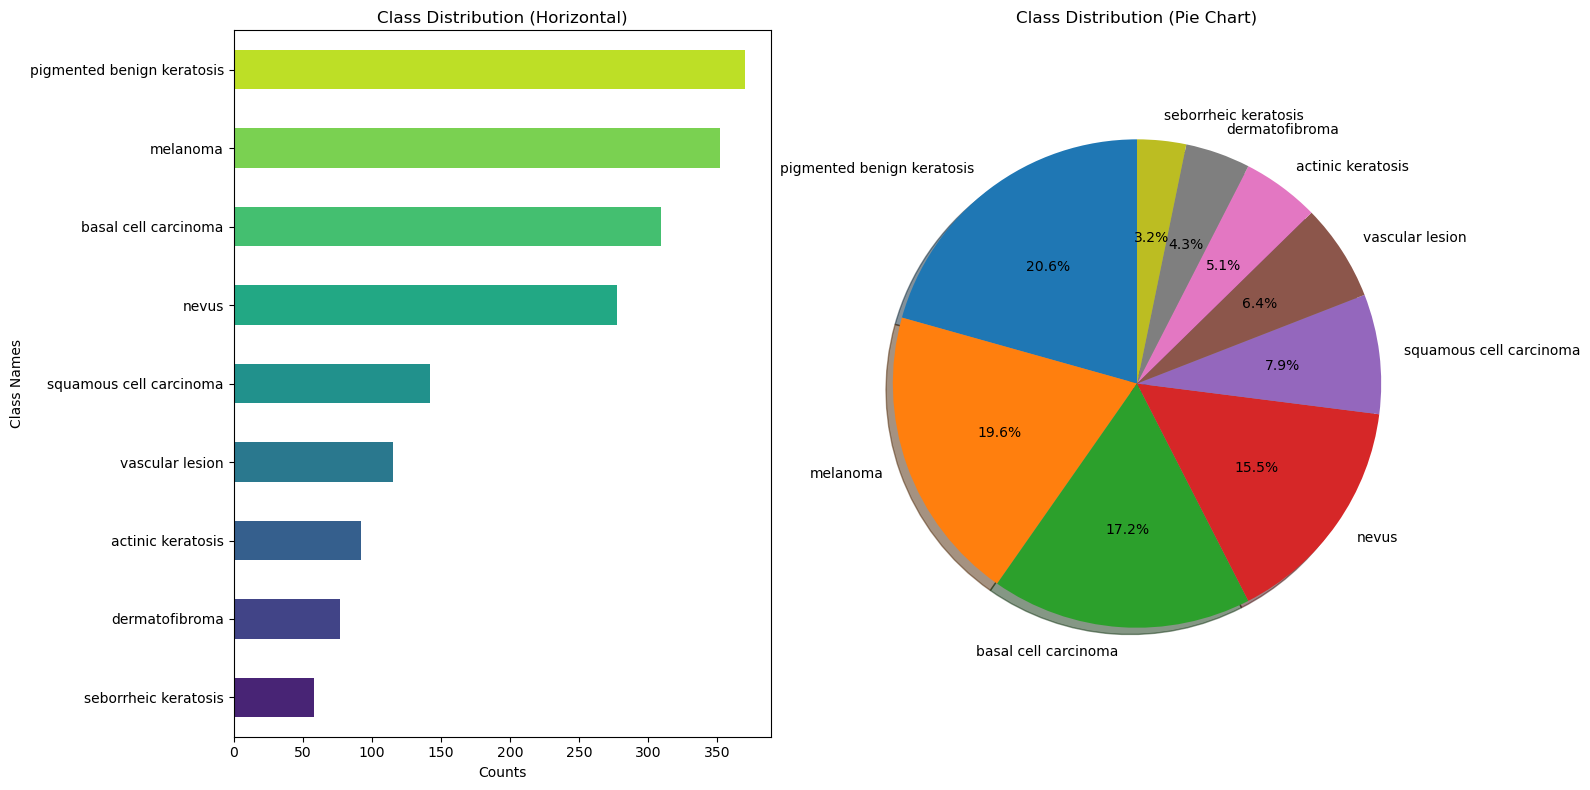

In [60]:
# First get the frequency data (this is from your original code)
labels = []
for x, y in train_ds:
  labels.append(y.numpy())
labels = np.concatenate(labels, axis=0)
train_df = pd.DataFrame(labels)
train_df.columns = ['Index']
train_df['Label'] = train_df['Index'].apply(lambda x: class_names[x])
freq = train_df['Label'].value_counts()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))

# 1. Horizontal Bar Chart
freq.sort_values().plot(
    kind='barh',
    color=sns.color_palette("viridis", len(freq)),
    ax=ax1
)
ax1.set_xlabel("Counts")
ax1.set_ylabel("Class Names")
ax1.set_title("Class Distribution (Horizontal)")

# 2. Pie Chart
ax2.pie(
    freq.values,
    labels=freq.index,
    autopct='%1.1f%%',
    startangle=90,
    shadow=True,
    colors=sns.color_palette("tab10", len(freq))
)
ax2.axis('equal')  # Makes pie chart a circle
ax2.set_title("Class Distribution (Pie Chart)")

plt.tight_layout()
plt.show()


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? Seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples? Pigmented Benign Keratosis, Melanoma and Basal Cell Carcinoma


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [61]:
%pip install Augmentor

Note: you may need to restart the kernel to use updated packages.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [62]:
path_to_training_dataset="C:/Users/sridh/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:/Users/sridh/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CF555B1C10>: 100%|██████████| 500/500 [00:01<00:00, 460.54 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to C:/Users/sridh/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CF5A772B40>: 100%|██████████| 500/500 [00:01<00:00, 471.57 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:/Users/sridh/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CF5B986D50>: 100%|██████████| 500/500 [00:01<00:00, 444.58 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to C:/Users/sridh/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CF702FAA50>: 100%|██████████| 500/500 [00:03<00:00, 126.16 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to C:/Users/sridh/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1CF580C1FD0>: 100%|██████████| 500/500 [00:04<00:00, 122.80 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to C:/Users/sridh/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CF5B984380>: 100%|██████████| 500/500 [00:01<00:00, 432.17 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to C:/Users/sridh/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CF592A5580>: 100%|██████████| 500/500 [00:01<00:00, 255.59 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:/Users/sridh/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CF0030FE60>: 100%|██████████| 500/500 [00:01<00:00, 446.45 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to C:/Users/sridh/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CF7072FD70>: 100%|██████████| 500/500 [00:01<00:00, 448.72 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [63]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [64]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['C:\\Users\\sridh\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2a26cc3c-fa03-4e1b-aa40-d4bbf8c7e2e0.jpg',
 'C:\\Users\\sridh\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_5368a865-7a2d-441d-aa6d-bbb1ae91ed66.jpg',
 'C:\\Users\\sridh\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8279ff95-da2e-4505-bd0a-f6802118e769.jpg',
 'C:\\Users\\sridh\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_bb19a27e-f927-4fac-ae35-d847d90598bd.jpg',
 'C:\\Users\\sridh\\Downloads\\CNN_assignment\\Skin cancer ISIC The Internat

In [65]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [66]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [67]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [68]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [69]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [70]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [71]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [102]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),

])

#### **Todo:** Create your model (make sure to include normalization)

In [103]:
model = Sequential([
   data_augmentation,
    layers.Rescaling(1./255),
    
    # First conv block
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Second conv block
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Third conv block
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),  # Smaller dense layer
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [104]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
batch_size = 32
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#### **Todo:**  Train your model

In [108]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 216ms/step - accuracy: 0.5868 - loss: 1.0527 - val_accuracy: 0.6407 - val_loss: 0.9766
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 215ms/step - accuracy: 0.6167 - loss: 1.0317 - val_accuracy: 0.6347 - val_loss: 0.9586
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 0.6193 - loss: 0.9972 - val_accuracy: 0.6533 - val_loss: 0.9165
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 0.6084 - loss: 1.0027 - val_accuracy: 0.6422 - val_loss: 0.9578
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 0.6345 - loss: 0.9820 - val_accuracy: 0.6563 - val_loss: 0.9379
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 216ms/step - accuracy: 0.6153 - loss: 0.9835 - val_accuracy: 0.6682 - val_loss: 0.9370
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 217ms/step - accuracy: 0.6412 - loss: 0.9375 - val_accuracy: 0.6830 - val_loss: 0.8934
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 215ms/step - accuracy: 0.6567 - loss: 0

#### **Todo:**  Visualize the model results

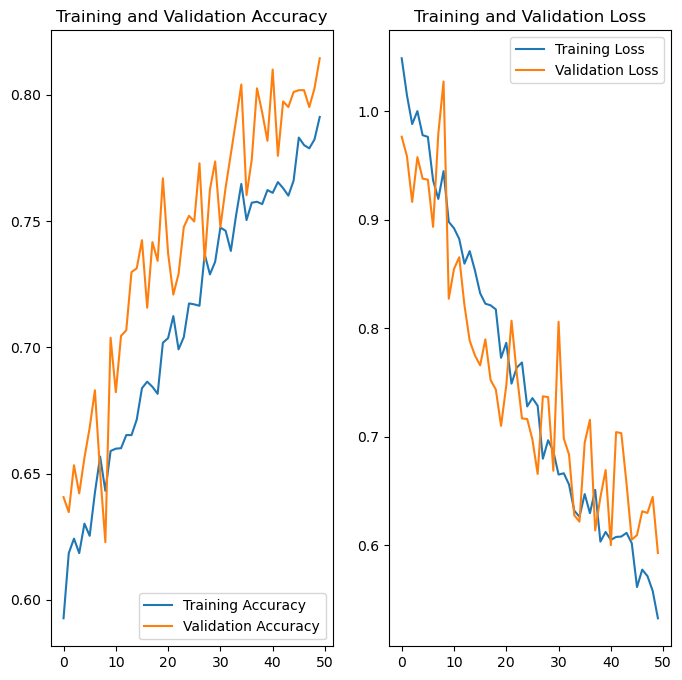

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Overfitting is gone to an major extent
- Validation Accuracy is 0.8482
- Training and Validation almost similar 0.781 and 0.814 , similar pattern for training and validation loss